### **Hailstorm Damage Assessment in Assiniboia, Saskatchewan, Canada on the 4th of July, 2020.**

##### Data: Sentinel-2 images acquired between July 2nd and July 6th, 2020

##### Content:
- Data retrieval
- Visual exploration
- Computation of indices
- Change analysis
- Area estimation
- Summary


In [38]:
%%capture
# !python -m pip uninstall matplotlib
!pip install rasterio
!pip install geopandas
!pip install matplotlib==3.1.3
!pip install earthpy

In [39]:
#@title **Workspace utilities:** *Import required libraries*

import io
import os

import numpy as np
import matplotlib.pyplot as plt
import rasterio

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from sklearn import cluster
from osgeo import gdal, gdal_array

from matplotlib.colors import ListedColormap
from matplotlib import image

from rasterio.plot import show
from rasterio.plot import show_hist
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from PIL import Image

In [40]:
#@title **Utility variables**
CLIENT_ID = "13e50afb-fe1a-47cc-a07b-938d62d00eff"
CLIENT_SECRET= "lVRd[}*gtI)H_9fmy[?[7<pw5,Ts66Lq/5<B^7V>"

# set up credentials
client = BackendApplicationClient(client_id=CLIENT_ID)
oauth = OAuth2Session(client=client)

# get an authentication token
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

bbox = [-106.10115, 49.66474, -105.92874, 49.56508]
collection_id = "sentinel-2-l2a"

In [41]:
#@title **How many images are available?**

start_date = "2020-06-03"
end_date = "2020-06-05"
json_search = {
    'bbox': bbox,
    'datetime': f'{start_date}T00:00:00Z/{end_date}T23:59:59Z',
    'collections': [collection_id],
    'limit': 2
}


# set the url and headers
url_search = 'https://services.sentinel-hub.com/api/v1/catalog/search'
headers_search = {
  'Content-Type': 'application/json'
}

# send the request
response_search = oauth.request(
    "POST", url_search, headers=headers_search, json = json_search
)

response_search.json()["context"]
#.keys()

{'limit': 2, 'returned': 2}

In [42]:
#@title **Request pre hail storm and post hail storm images**
evalscript = """
//VERSION=3
function setup(){
    return {
      input: ["B03", "B04", "B08"],
      output: [{id: "img", bands: 3, sampleType: "AUTO"}], 
        };
  }

function evaluatePixel(sample) {
    return {
      "img": [2.5 * sample.B08, 2.5 * sample.B04, 2.5 * sample.B03]
    }
  }
  """

json_request_pre = {
  "input": {
    "bounds": {
      "bbox": [
        -106.10115,
        49.56508,
        -105.92874,
        49.66474
      ]
    },
    "data": [
      {
        "dataFilter": {
          "timeRange": {
            "from": "2020-07-03T00:00:00Z",
            "to": "2020-07-03T23:59:59Z"
          }
        },
        "type": "sentinel-2-l2a"
      }
    ]
  },
  "output": {
    "width": 512,
    "height": 456.312,
    "responses": [
      {
        "identifier": "img",
        "format": {
          "type": "image/tiff"
        }
      }
    ]
  },
  "evalscript": evalscript
}

json_request_post = {
  "input": {
    "bounds": {
      "bbox": [
        -106.10115,
        49.56508,
        -105.92874,
        49.66474
      ]
    },
    "data": [
      {
        "dataFilter": {
          "timeRange": {
            "from": "2020-07-04T00:00:00Z",
            "to": "2020-07-06T23:59:59Z"
          }
        },
        "type": "sentinel-2-l2a"
      }
    ]
  },
  "output": {
    "width": 512,
    "height": 456.312,
    "responses": [
      {
        "identifier": "img",
        "format": {
          "type": "image/tiff"
        }
      }
    ]
  },
  "evalscript": evalscript
}

# Set the request url and headers
url_request = "https://services.sentinel-hub.com/api/v1/process"
headers_request = {
    "Authorization" : "Bearer %s" %token['access_token']
}

response_pre = oauth.request(
    "POST", url_request, headers=headers_request, json=json_request_pre
)

response_post = oauth.request(
    "POST", url_request, headers=headers_request, json=json_request_post
)

Text(0.5, 1.0, 'Post Hailstorm image')

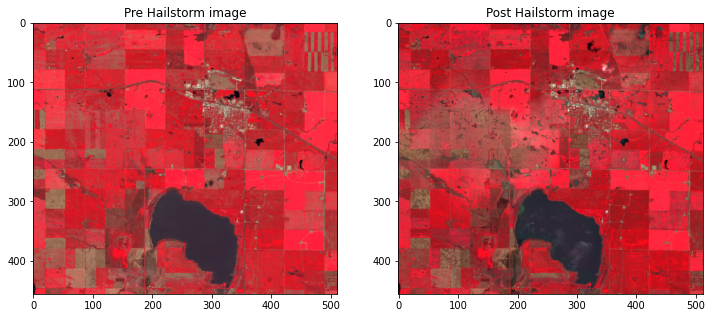

In [43]:
#@title **False color visualization of pre and post damage images**

# read the image as numpy array
image_pre = np.array(Image.open(io.BytesIO(response_pre.content)))
image_post = np.array(Image.open(io.BytesIO(response_post.content)))

image_pre = np.clip(image_pre, 0, 255)
image_post = np.clip(image_post, 0, 255)

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].imshow(image_pre, cmap="gray")
axs[0].set_title("Pre Hailstorm image")

axs[1].imshow(image_post, cmap="gray")
axs[1].set_title("Post Hailstorm image")

In [44]:
#@title **SAVI computation and visualization for pre and post damage images**

def savi(image_pre, image_post):
  
  # select respective image bands
  red_pre = image_pre[:,:, 1].astype ('f4')
  nir_pre = image_pre[:,:, 2].astype ('f4')
  
  red_post = np.clip(image_post[:,:, 1].astype ('f4'), 0, 255)
  nir_post = np.clip(image_post[:,:, 2].astype ('f4'), 0, 255)
  
  SAVI_pre = ((nir_pre - red_pre)/ (nir_pre + red_pre + 0.5)) * (1 + 0.5)
  SAVI_post = ((nir_post - red_post)/ (nir_post + red_post + 0.5)) * (1 + 0.5)
  
  # visualize output
  fig, axs = plt.subplots(1, 2, figsize=(12, 8))
  
  axs[0].imshow(SAVI_pre, cmap='terrain_r')
  axs[0].set_title("SAVI Pre Hailstorm")
  
  im = axs[1].imshow(SAVI_post, cmap="terrain_r")
  axs[1].set_title("SAVI Post Hailstorm")
  #fig.colorbar(SAVI_pre) 
  fig.colorbar(im, ax=axs.ravel().tolist())

  return SAVI_pre, SAVI_post

def image_differencing(SAVI_pre, SAVI_post):
  change= SAVI_pre - SAVI_post
  #plot change image
  plt.imshow(change, cmap='RdYlGn')
  plt.title("Difference image")
  plt.colorbar()
  return change

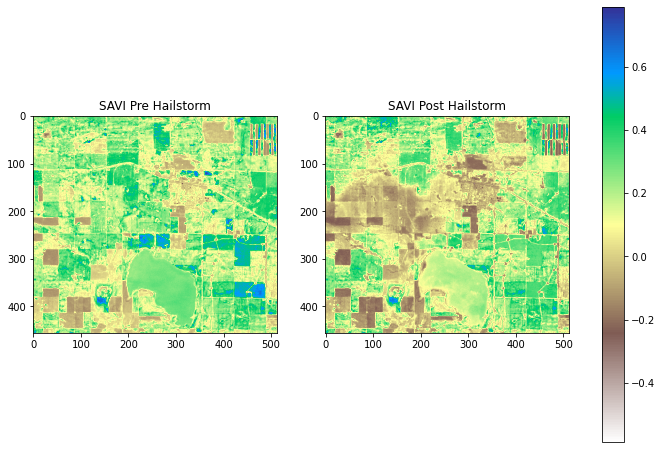

In [45]:
#Call SAVI function
SAVI_pre, SAVI_post = savi(image_pre, image_post)

In [46]:
#Check the minimum value and maximum value
np.unique(SAVI_post)

array([-0.5868132 , -0.4836272 , -0.44210523, ...,  0.7058824 ,
        0.71999997,  0.7894737 ], dtype=float32)

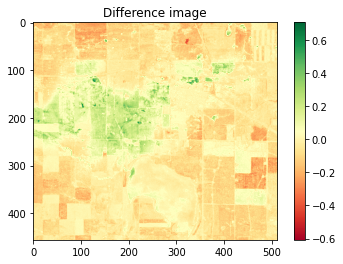

In [47]:
#Call Image Differencing function
change = image_differencing(SAVI_pre, SAVI_post)

### Image binarization
Here I would like to propose two methods in due to classifying the difference image:

- Manual thresholding : differenciate the image by visual interpretation
- Otsu thresholding : automaticaly determine threshold value

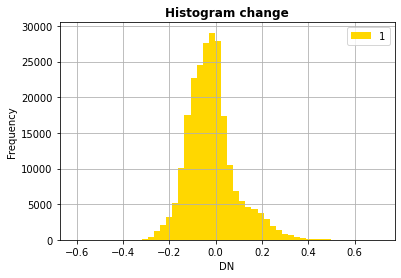

In [48]:
# check image histogram
show_hist(change, bins=50, title= 'Histogram change')

In [49]:
#@title **Classify Damaged Area**

#classify Difference image
#classify into binary values: below 0.1 and above 0.1

#define the threshold value of the classes
thresh = 0.1


def classify_damage(thresh, change_img):
  change_class_bins= [-np.inf,thresh,np.inf]
  damage_classes = np.digitize(change_img, change_class_bins)
  plt.imshow(damage_classes, cmap="gray")
  plt.legend(np.unique(damage_classes))
  plt.title("Damaged area")
  return damage_classes



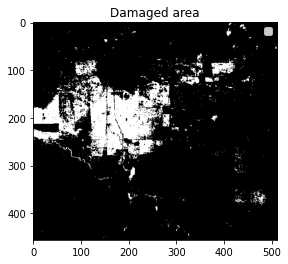

In [50]:
#Call classify the change image into two classes function
damage_classes = classify_damage(thresh, change)

In [51]:
#check the change_classes value
damage_classes
# 1 = non damaged
# 2 = damaged

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [52]:
#@title **Area estimation from manual thresholding method**

#Calculate changed class from manual thresholding method
total_area_damaged_mquare= np.sum(damage_classes==2)*100
total_area_damaged_mquare
print(total_area_damaged_mquare, 'meters square')

2762900 meters square


In [53]:
#Damaged agriculture area calculation
hectares_damaged_area = total_area_damaged_mquare/10000
print(hectares_damaged_area, ' hectares')

276.29  hectares


In [54]:
#@title **Classify change with Otsu algorithm** 
from skimage.filters import threshold_otsu
def classify_damage_otsu(change_img):
  thresh =  threshold_otsu(change)
  change_classes = change > thresh
  plt.imshow(change_classes, cmap="gray")
  plt.legend(np.unique(change_classes))
  plt.title("Damaged area - Otsu thresholding")
  return change_classes



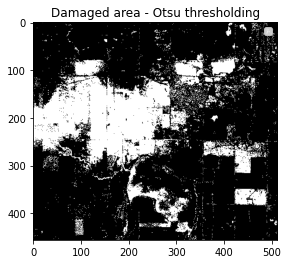

In [55]:
#Call Classify change Otsu function
damage_classes_otsu = classify_damage_otsu(change)

In [56]:
#Check change_classes_otsu
damage_classes_otsu

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [57]:
#@title **Area estimation from Otsu thresholding method**

#Calculate changed class from manual thresholding method
otsu_total_area_damaged_msquare= np.sum(damage_classes_otsu==True)
print(otsu_total_area_damaged_msquare, ' meters square')


59241  meters square


In [58]:
#Damaged agriculture area calculation
otsu_hectares_damaged_area=otsu_total_area_damaged_msquare/10000
print(otsu_hectares_damaged_area, ' hectares')

5.9241  hectares


##**Summary**

Damage assessment caused by hailstorm event in agricultural land, Assiniboia, Saskatchewan, Canada can be observed by satellite EO-based data, particularly Sentinel-2A because of three main reasons: the area is accommodated by one scene of image, the condition before and after hail event is captured without long gap (a day before and 2 days after) therefore the difference is mainly caused by the natural disaster, and the availability of spectral bands that sensitive with the health condition of vegetation. SAVI index is utilized to identify agricultural land that affected by the storm. Change assessment is performed with input from SAVI index before and after the hail event. Then from the difference value, the damaged area can be identified and calculated. 

There are two methods that proposed here in order to classifying the damaged and non damaged area, first method relies on visual interpretation for determining the threshold value and the second method is Otsu thresholding which carries the capability of automatically determining the threshold value. However, the manual threshold method shows better deliniaton rather than Otsue threshold method. This is due to the method mostly suitable for data with bimodal histogram. By taking into account the mentioned limitations, this proposed workflow is still leave room for improvement. However, this technical workflow was effectively addressed the challenge and worth implementing. Additionally, with fully performed in python environment which allows to be reproduced and applied for other case studies with some additional improvement in due to create an agile monitoring crop system. 
